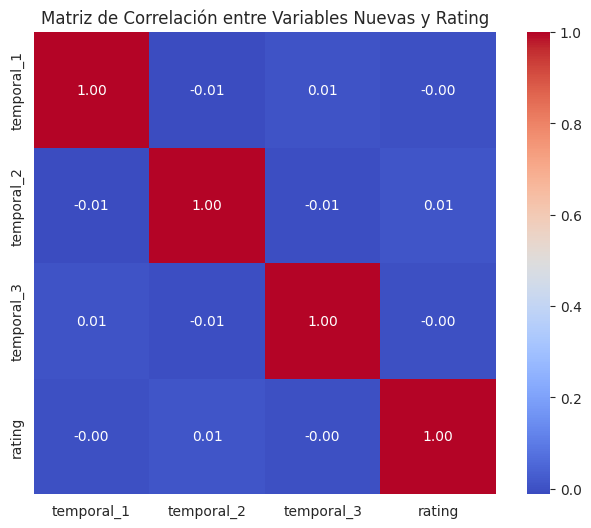


📊 Correlación de Variables con Rating:

temporal_2    0.008290
temporal_3   -0.000712
temporal_1   -0.003026
Name: rating, dtype: float64


In [2]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 1. Cargar tu dataset limpio (el que tiene temporal_1, temporal_2, temporal_3, etc.)
df = pd.read_csv("dataset_rnn_ready.csv")

# 🔹 2. Seleccionar las columnas que quieres analizar
features = ['temporal_1', 'temporal_2', 'temporal_3']  # puedes agregar más si tienes
features.append('rating')  # agregamos el rating para la correlación

# 🔹 3. Calcular la matriz de correlación
correlation_matrix = df[features].corr()

# 🔹 4. Visualizar la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación entre Variables Nuevas y Rating")
plt.show()

correlation_with_rating = correlation_matrix['rating'].drop('rating').sort_values(ascending=False)

print("\n📊 Correlación de Variables con Rating:\n")
print(correlation_with_rating)


In [3]:

import pandas as pd
import numpy as np
from fastFM import sgd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import sparse

df = pd.read_csv("dataset_rnn_ready.csv")

X = df[['temporal_1', 'temporal_2', 'temporal_3']]
y = df['rating']

# 🔹 3. Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a sparse matrix (porque fastFM necesita sparse)
X_sparse = sparse.csr_matrix(X_scaled)

# 🔹 4. Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# 🔹 5. Crear el modelo Factorization Machine
fm = sgd.FMRegression(n_iter=1000, init_stdev=0.1, l2_reg_w=0.1, l2_reg_V=0.5, rank=8, random_state=42)

# 🔹 6. Entrenar el modelo
fm.fit(X_train, y_train)

# 🔹 7. Predecir
y_pred = fm.predict(X_test)

# 🔹 8. Evaluar con RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n🔍 RMSE obtenido en test: {rmse:.4f}")




🔍 RMSE obtenido en test: 1.0838


In [4]:
# 📚 Librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 🔹 1. Cargar el dataset
df = pd.read_csv("dataset_rnn_ready.csv")
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

# 🔹 2. Construir features temporales
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

def get_season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3
df['season_encoded'] = df['month'].apply(get_season)
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
df['is_holiday'] = 0  # Placeholder feriados

# 🔹 3. Crear 'rating_previous' primero
df = df.sort_values(['userId', 'timestamp'])
df['rating_previous'] = df.groupby('userId')['rating'].shift()
df['rating_previous'] = df['rating_previous'].fillna(0)

# 🔹 4. Crear nuevas variables
df['week_of_year'] = df['date'].dt.isocalendar().week

consumo_semanal = df.groupby(['userId', 'week_of_year']).size().reset_index(name='consumo_semanal_usuario')
df = df.merge(consumo_semanal, on=['userId', 'week_of_year'], how='left')

año_actual = 2025
df['antiguedad_rating'] = año_actual - df['year']

df['diferencia_rating_anterior'] = df['rating'] - df['rating_previous']
df['diferencia_rating_anterior'] = df['diferencia_rating_anterior'].fillna(0)

# 🔹 5. Confirmar
print(df[['userId', 'rating_previous', 'week_of_year', 'consumo_semanal_usuario', 'antiguedad_rating', 'diferencia_rating_anterior']].head())

# 🔹 6. Seleccionar features finales
features = [
    'userId', 'movieId',
    'temporal_1', 'temporal_2', 'temporal_3',
    'rating_previous',
    'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario',
    'antiguedad_rating',
    'diferencia_rating_anterior'
]

X = df[features]
y = df['rating']

# 🔹 7. Partir Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Nuevos datos preparados. Shape X_train: {X_train.shape}, y_train: {y_train.shape}")


   userId  rating_previous  week_of_year  consumo_semanal_usuario  \
0       1              0.0            46                        3   
1       1              5.0            46                        3   
2       1              5.0            46                        3   
3       1              1.0            47                        3   
4       1              2.0            47                        3   

   antiguedad_rating  diferencia_rating_anterior  
0                 26                         5.0  
1                 26                         0.0  
2                 26                        -4.0  
3                 26                         1.0  
4                 26                         3.0  
✅ Nuevos datos preparados. Shape X_train: (4266694, 15), y_train: (4266694,)


In [5]:
# Preparar los inputs separados
X_train_user = X_train['userId'].values
X_train_movie = X_train['movieId'].values
X_train_others = X_train.drop(['userId', 'movieId'], axis=1).values
X_train_others = X_train_others.reshape((X_train_others.shape[0], 1, X_train_others.shape[1]))

X_test_user = X_test['userId'].values
X_test_movie = X_test['movieId'].values
X_test_others = X_test.drop(['userId', 'movieId'], axis=1).values
X_test_others = X_test_others.reshape((X_test_others.shape[0], 1, X_test_others.shape[1]))


In [11]:
# 📚 Importar librerías necesarias
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, SimpleRNN
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf


# 🔹 Número de usuarios y películas
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

# 🔹 1. Definir Inputs
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
other_features_input = Input(shape=(1, 13), name='other_features_input')

# 🔹 2. Embeddings
user_embedding = Embedding(input_dim=n_users+1, output_dim=16, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=n_movies+1, output_dim=16, name='movie_embedding')(movie_input)

user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

embedding_concat = Concatenate()([user_vec, movie_vec])
embedding_concat = tf.expand_dims(embedding_concat, axis=1)

# 🔹 3. Combinar embeddings + otras features
combined = Concatenate(axis=-1)([embedding_concat, other_features_input])

# 🔹 4. RNN + Densas
rnn_out = SimpleRNN(128, activation='tanh')(combined)
dense1 = Dense(64, activation='relu')(rnn_out)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# 🔹 5. Modelo
model = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)

# 🔹 6. Compilar
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 🔹 7. Mostrar resumen del modelo
model.summary()

# --------------------------------------------------
# 📚 Entrenar el modelo

history = model.fit(
    [X_train_user, X_train_movie, X_train_others], y_train,
    validation_data=([X_test_user, X_test_movie, X_test_others], y_test),
    epochs=10,          # Puedes aumentar a 15 o 20 si quieres mejor resultado
    batch_size=1024,    # Ajusta si ves que tu RAM lo soporta
    verbose=1
)

# --------------------------------------------------
# 📚 Evaluar el modelo

loss, rmse = model.evaluate([X_test_user, X_test_movie, X_test_others], y_test, verbose=1)
print(f"\n✅ RMSE final de la RNN Pro mejorada: {rmse:.4f}")

# --------------------------------------------------
# 📚 Calcular métricas de clasificación

# 1. Predecir ratings
y_pred_continuous = model.predict([X_test_user, X_test_movie, X_test_others]).flatten()

# 2. Calcular RMSE manual (opcional para confirmar)
rmse_manual = np.sqrt(mean_squared_error(y_test, y_pred_continuous))
print(f"✅ RMSE (manual check): {rmse_manual:.4f}")

# 3. Convertir a categorías
y_pred_class = np.round(y_pred_continuous)
y_true_class = np.round(y_test)

# 4. Calcular métricas
accuracy = accuracy_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class, average='weighted', zero_division=0)
recall = recall_score(y_true_class, y_pred_class, average='weighted')
f1 = f1_score(y_true_class, y_pred_class, average='weighted')

# 5. Mostrar métricas
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")

model.save("modelo_rnn.h5")
print("Modelo guardado con exito ")


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 16)                3206160   ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 16)                814080    ['movie_input[0][0]']         
 )                                                                                          

/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# 📚 Predecir en el test set
y_pred_continuous = model.predict([X_test_user, X_test_movie, X_test_others]).flatten()

# 🔹 Seleccionamos 5 ejemplos aleatorios para mostrar
import random

# Escogemos 5 índices aleatorios
random_indices = random.sample(range(len(y_test)), 5)

print("\n Ejemplos de predicción:\n")
for idx in random_indices:
    print(f"Usuario ID: {X_test_user[idx]}")
    print(f"Película ID: {X_test_movie[idx]}")
    print(f"Rating real: {y_test.iloc[idx]:.1f}")
    print(f"Rating predicho: {y_pred_continuous[idx]:.2f}")
    print("-" * 40)


33334/33334 [==============================] - 50s 1ms/step

 Ejemplos de predicción:

Usuario ID: 35487
Película ID: 3169
Rating real: 5.0
Rating predicho: 4.99
----------------------------------------
Usuario ID: 47855
Película ID: 1580
Rating real: 3.0
Rating predicho: 3.00
----------------------------------------
Usuario ID: 166256
Película ID: 2916
Rating real: 3.5
Rating predicho: 3.53
----------------------------------------
Usuario ID: 69545
Película ID: 541
Rating real: 4.5
Rating predicho: 4.53
----------------------------------------
Usuario ID: 105725
Película ID: 45
Rating real: 2.0
Rating predicho: 2.02
----------------------------------------


In [15]:
# 📚 Análisis estadístico de las predicciones
import numpy as np

min_rating = np.min(y_pred_continuous)
max_rating = np.max(y_pred_continuous)
mean_rating = np.mean(y_pred_continuous)
std_rating = np.std(y_pred_continuous)

print("\n Análisis de las predicciones:\n")
print(f" Mínimo rating predicho: {min_rating:.2f}")
print(f" Máximo rating predicho: {max_rating:.2f}")
print(f" Promedio de ratings predichos: {mean_rating:.2f}")
print(f" Desviación estándar de ratings predichos: {std_rating:.2f}")



 Análisis de las predicciones:

 Mínimo rating predicho: 0.63
 Máximo rating predicho: 5.02
 Promedio de ratings predichos: 3.54
 Desviación estándar de ratings predichos: 1.06
